In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import camb

In [2]:
#Reading map and mask
mapt = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=0)
mapq = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=1)
mapu = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=2)
maskt = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=3)
maskp = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=4)
npix = mapt.shape[0]
maps=np.ndarray(shape=(3,npix))
maps[0,:] = mapt*maskt
maps[1,:] = mapq*maskp
maps[2,:] = mapu*maskp

In [3]:
#sky fraction
countt=0
countp=0
el = np.ndarray(shape=(1501))
  # right till this
for i in range(npix):
    if maskt[i]==1.0:
        countt=countt+1
    if maskp[i]==1.0:
        countp=countp+1    
skyfract = countt/npix
skyfracp = countp/npix
print(skyfracp)
print(skyfract)

#Cant use synfast to convert these Cls to obtain map because itll be just one realization of the alms 

0.9294650157292684
0.8424085974693298


In [4]:
#Getting alms,elms and blms
alms = hp.map2alm(maps,pol=True,lmax=1500)
emap = hp.alm2map(alms[1,:],pol=False,lmax=1500,nside=2048) #check if mask needs to be mutilplied here as well
bmap = hp.alm2map(alms[2,:],pol=False,lmax=1500,nside=2048)

In [5]:
#Calculatin cls using masked mapss
Cl = hp.anafast(maps,lmax=1500,pol=True)
for i in range(0,1501):
    el[i] = i
Cl[0,:] = el*(el+1)*Cl[0,:]/((2*np.pi)*skyfract)
Cl[1,:] = el*(el+1)*Cl[1,:]/((2*np.pi)*skyfracp)
Cl[2,:] = skyfracp*el*(el+1)*Cl[2,:]/((2*np.pi)*skyfracp)
Cl[3,:] = el*(el+1)*Cl[3,:]/(2*np.pi)

In [6]:

Cl_ee = hp.anafast(emap,pol=False,lmax=1500)
Cl_bb = hp.anafast(bmap,pol=False,lmax=1500)


In [7]:
Cl_ee = el*(el+1)*Cl_ee*10**12/((2*np.pi)*skyfracp)
Cl_bb = el*(el+1)*Cl_bb*10**12/((2*np.pi)*skyfracp)

In [8]:
#Correlation cl_te
cl_te = hp.anafast(maps[0,:],emap,lmax=1500)
cl_te = el*(el+1)*cl_te*10**12/((2*np.pi)*np.sqrt(skyfract*skyfracp)) #check if right

In [9]:
camb.run_ini('planck_2018_acc.ini', no_validate=False)
pars = camb.read_ini('planck_2018_acc.ini')


at z =  0.000 sigma8 (all matter) =  0.8120
at z =  0.000 sigma8^2_vd/sigma8  =  0.4293


In [10]:
 #We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

#pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=1500).T
cls_len = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3]}

<Figure size 1500x600 with 0 Axes>

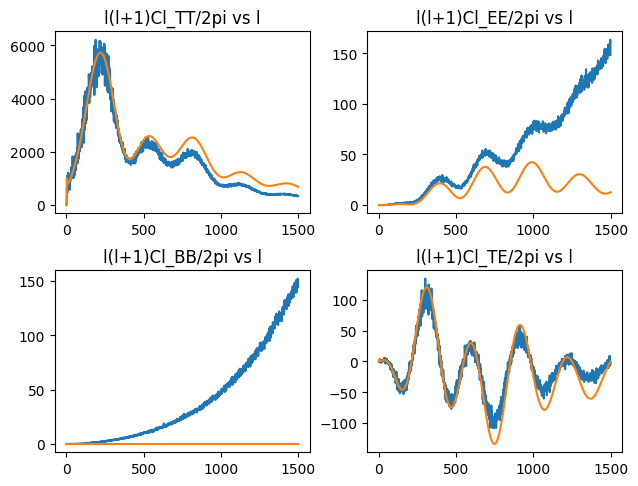

In [27]:
plt.figure(figsize=(15, 6))
fig, ax = plt.subplots(2, 2)
fig.tight_layout(h_pad=2)
plt.subplot(2,2,1)
plt.title('l(l+1)Cl_TT/2pi vs l')
plt.plot(el,Cl[0,:]*10**12)
plt.plot(el,el*(el+1)*camb_cls_len[0,:]/(2*np.pi))
plt.subplot(2,2,2)

plt.title('l(l+1)Cl_EE/2pi vs l')
plt.plot(el,Cl_ee)
plt.plot(el,el*(el+1)*camb_cls_len[1,:]/(2*np.pi))

plt.subplot(2,2,3)
plt.title('l(l+1)Cl_BB/2pi vs l')
plt.plot(el,Cl_bb)
plt.plot(el,el*(el+1)*camb_cls_len[2,:]/(2*np.pi))

plt.subplot(2,2,4)
plt.title('l(l+1)Cl_TE/2pi vs l')
plt.plot(el,cl_te)
plt.plot(el,el*(el+1)*camb_cls_len[3,:]/(2*np.pi))



/tmp/ipykernel_550959/3971059055.py:1: RuntimeWarning: invalid value encountered in divide
  Nl_ee = (Cl_ee - el*(el+1)*camb_cls_len[1,:]/(2*np.pi))/el*(el+1)*camb_cls_len[1,:]


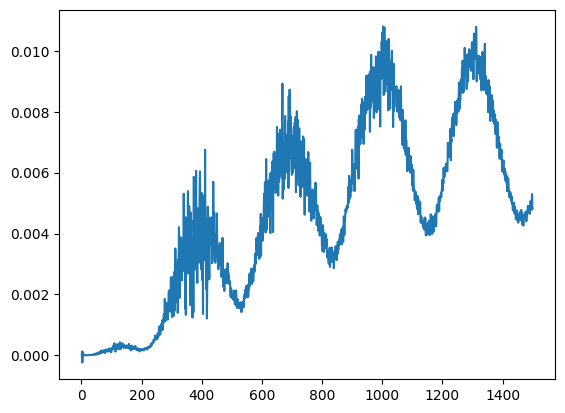

In [17]:
Nl_ee = (Cl_ee - el*(el+1)*camb_cls_len[1,:]/(2*np.pi))/el*(el+1)*camb_cls_len[1,:]
plt.plot(el,Nl_ee)

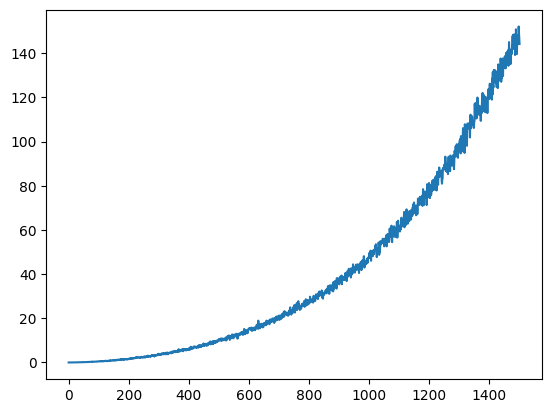

In [16]:
Nl_bb = Cl_bb - el*(el+1)*camb_cls_len[2,:]/(2*np.pi)
plt.plot(el,Nl_bb)

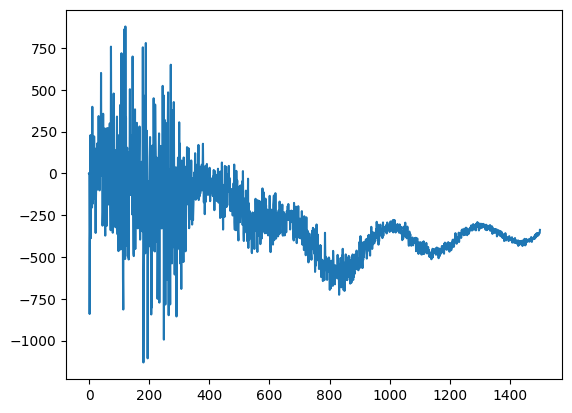

In [18]:
Nl_tt = Cl[0,:]*10**12 - el*(el+1)*camb_cls_len[0,:]/(2*np.pi)
plt.plot(el,Nl_tt)

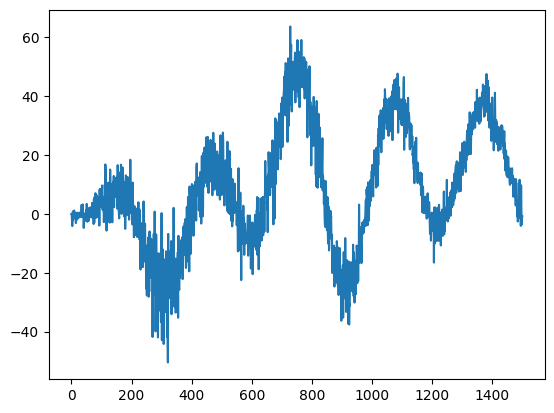

In [19]:
Nl_te = Cl[3,:]*10**12 - el*(el+1)*camb_cls_len[3,:]/(2*np.pi)
plt.plot(el,Nl_te)

In [20]:
#another method to obtain emap and bmap
#input Q and U maps
xlms = hp.map2alm_spin(maps[1:,:],2,lmax=1500)

In [22]:
emap = hp.alm2map(xlms[0],pol=False,lmax=1500,nside=2048)
bmap = hp.alm2map(xlms[1],pol=False,lmax=1500,nside=2048)

In [23]:
Cl_ee1 = hp.anafast(emap,lmax=1500,pol=False)
Cl_bb1 = hp.anafast(bmap,lmax=1500,pol=False)
Cl_ee1 = el*(el+1)*Cl_ee1/(2*np.pi)*10**12
Cl_bb1 = el*(el+1)*Cl_bb1/(2*np.pi)*10**12

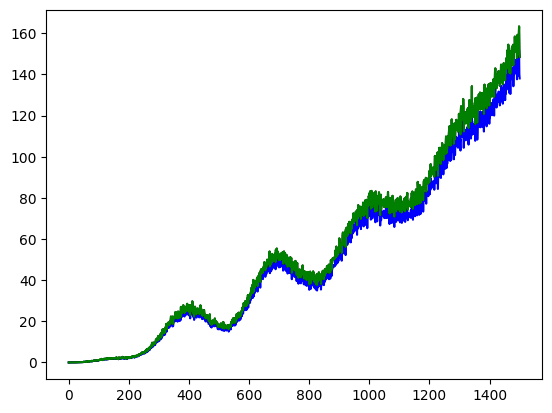

In [44]:
#Comparison of ee and bb power spectrum from three diff methods?
plt.plot(el,Cl_ee1,color='blue')  #this
plt.plot(el,Cl_ee,color='black')
plt.plot(el,Cl[1,:]*10**12,color='green') # and this are matchin ==> spin map2alm and anafast

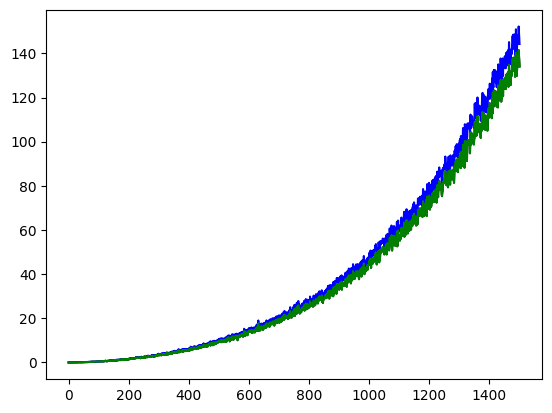

In [46]:
plt.plot(el,Cl_bb1,color='black')
plt.plot(el,Cl_bb,color='blue')
plt.plot(el,Cl[2,:]*10**12,color='green')